### Imports

In [1]:
from tqdm import tqdm
import random
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import gymnasium as gym
import gym_mtsim
sys.path.append("C:/Users/WilliamFetzner/Documents/Trading/")
from gym_mtsim_forked.gym_mtsim.data import FOREX_DATA_PATH, FOREX_DATA_PATH_1HR, FOREX_DATA_PATH_15MIN, FOREX_DATA_PATH_5MIN
from gym_mtsim import OrderType, Timeframe, MtEnv, MtSimulator
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, STATUS_FAIL
from stable_baselines3 import A2C, PPO
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback
import time
import torch
import pickle
import fx_rl
from datetime import datetime, timedelta
import pytz

c:\Users\WilliamFetzner\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\envs\registration.py:694: UserWarning: WARN: Overriding environment forex-hedge-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
c:\Users\WilliamFetzner\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\envs\registration.py:694: UserWarning: WARN: Overriding environment forex-unhedge-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
c:\Users\WilliamFetzner\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\envs\registration.py:694: UserWarning: WARN: Overriding environment stocks-hedge-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
c:\Users\WilliamFetzner\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\envs\registration.py:694: UserWarning: WARN: Overriding environment stocks-unhedge-v0 alr

## Latest Data

In [2]:
now = datetime.now()
current_time = pd.to_datetime(now) + timedelta(hours=7)
current_time = current_time.replace(tzinfo=pytz.UTC)
# date_15min = fx_rl.bars_back(current_time, 'M15')
# date_5min = fx_rl.bars_back(current_time, 'M5')
date_1hr = fx_rl.bars_back(current_time, 'H1', total_bars=50_000)


In [3]:
sim = MtSimulator(
    unit='USD',
    balance=10000.,
    leverage=100.,
    stop_out_level=0.2,
    hedge=False,
)
sim.download_data(
    symbols=['EURUSD', 'AUDCHF', 'NZDCHF', 'GBPNZD', 'USDCAD'],
    time_range=(
        date_1hr,
        current_time
    ),
    timeframe=Timeframe.H1
)
sim.save_symbols(FOREX_DATA_PATH)
# sim.save_symbols(f'symbols_forex_15min_{date_1hr.date()}_{current_time.date()}.pkl')

In [4]:
# with open(f'symbols_forex_5min_2023-01-09_2024-05-08', 'rb') as f:
#     symbols_5min = pickle.load(f)
# # convert symbols_5min to a pd.dataframe
# symbols_5min[1]['EURUSD'].index = pd.to_datetime(symbols_5min[1]['EURUSD'].index)
# max_date_5min = symbols_5min[1]['EURUSD'].index.max()

In [5]:
# with open(f'symbols_forex_15min_2020-05-11_2024-05-08', 'rb') as f:
#     symbols_15min = pickle.load(f)
# # convert symbols_15min to a pd.dataframe
# symbols_15min[1]['EURUSD'].index = pd.to_datetime(symbols_15min[1]['EURUSD'].index)
# max_date_15min = symbols_15min[1]['EURUSD'].index.max()

In [6]:
with open(FOREX_DATA_PATH, 'rb') as f:
    symbols_1hr = pickle.load(f)
# convert symbols_1hr to a pd.dataframe
symbols_1hr[1]['EURUSD'].index = pd.to_datetime(symbols_1hr[1]['EURUSD'].index)
max_date_1hr = symbols_1hr[1]['EURUSD'].index.max()

In [7]:
# # unpack the pickle file and load the data that is in symbols_forex.pkl
# with open(FOREX_DATA_PATH, 'rb') as f:
#     symbols = pickle.load(f)
# # convert symbols to a pd.dataframe
# # symbols[1]['EURUSD']

In [8]:
# slices_5min = fx_rl.slices_finder(symbols_5min[1]['EURUSD'], max_date_5min, testing_needed=True)
# slices_15min = fx_rl.slices_finder(symbols_15min[1]['EURUSD'], max_date_15min, testing_needed=True)
slices_1hr = fx_rl.slices_finder(symbols_1hr[1]['EURUSD'], max_date_1hr, testing_needed=False)

### Create Env

In [9]:
# class MyMtEnv(gym_mtsim.MtEnv):
#     # _get_modified_volume = fx_rl.my_get_modified_volume
#     _get_prices = fx_rl.my_get_prices

In [10]:
sim_train_1hr = gym_mtsim.MtSimulator(
    unit='USD',
    balance=200000.,
    leverage=100.,
    stop_out_level=0.2,
    hedge=True,
    symbols_filename=FOREX_DATA_PATH
)

env_train_1hr = gym_mtsim.MtEnv(
    original_simulator=sim_train_1hr,
    trading_symbols=['EURUSD'],
    window_size = 10,
    time_points=slices_1hr[0],
    hold_threshold=0.5,
    close_threshold=0.5,
    fee=lambda symbol: {
        # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
        'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
        # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
    }[symbol],
    symbol_max_orders=2,
    multiprocessing_processes=2
)

In [11]:
# sim_train_15min = gym_mtsim.MtSimulator(
#     unit='USD',
#     balance=200000.,
#     leverage=100.,
#     stop_out_level=0.2,
#     hedge=True,
#     symbols_filename=FOREX_DATA_PATH_15MIN
# )

# env_train_15min = gym_mtsim.MtEnv(
#     original_simulator=sim_train_15min,
#     trading_symbols=['EURUSD'],
#     window_size = 10,
#     time_points=slices_15min[0],
#     hold_threshold=0.5,
#     close_threshold=0.5,
#     fee=lambda symbol: {
#         # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
#         'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
#         # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
#     }[symbol],
#     symbol_max_orders=2,
#     multiprocessing_processes=2
# )

In [12]:
# sim_train_5min = gym_mtsim.MtSimulator(
#     unit='USD',
#     balance=200000.,
#     leverage=100.,
#     stop_out_level=0.2,
#     hedge=True,
#     symbols_filename=FOREX_DATA_PATH_5MIN
# )

# env_train_5min = gym_mtsim.MtEnv(
#     original_simulator=sim_train_5min,
#     trading_symbols=['EURUSD'],
#     window_size = 10,
#     time_points=slices_5min[0],
#     hold_threshold=0.5,
#     close_threshold=0.5,
#     fee=lambda symbol: {
#         # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
#         'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
#         # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
#     }[symbol],
#     symbol_max_orders=2,
#     multiprocessing_processes=2
# )

In [13]:
sim_validation_1hr = MtSimulator(
    unit='USD',
    balance=200000.,
    leverage=100.,
    stop_out_level=0.2,
    hedge=True,
    symbols_filename=FOREX_DATA_PATH
)

env_validation_1hr = gym_mtsim.MtEnv(
    original_simulator=sim_validation_1hr,
    trading_symbols=['EURUSD'],
    window_size = 10,
    time_points=slices_1hr[1],
    hold_threshold=0.5,
    close_threshold=0.5,
    fee=lambda symbol: {
        # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
        'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
        # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
    }[symbol],
    symbol_max_orders=2,
    multiprocessing_processes=2
)

In [14]:
# sim_validation_15min = gym_mtsim.MtSimulator(
#     unit='USD',
#     balance=200000.,
#     leverage=100.,
#     stop_out_level=0.2,
#     hedge=True,
#     symbols_filename=FOREX_DATA_PATH_15MIN
# )

# env_validation_15min = gym_mtsim.MtEnv(
#     original_simulator=sim_validation_15min,
#     trading_symbols=['EURUSD'],
#     window_size = 10,
#     time_points=slices_15min[1],
#     hold_threshold=0.5,
#     close_threshold=0.5,
#     fee=lambda symbol: {
#         # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
#         'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
#         # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
#     }[symbol],
#     symbol_max_orders=2,
#     multiprocessing_processes=2
# )

In [15]:
# sim_validation_5min = gym_mtsim.MtSimulator(
#     unit='USD',
#     balance=200000.,
#     leverage=100.,
#     stop_out_level=0.2,
#     hedge=True,
#     symbols_filename=FOREX_DATA_PATH_5MIN
# )

# env_validation_5min = gym_mtsim.MtEnv(
#     original_simulator=sim_validation_5min,
#     trading_symbols=['EURUSD'],
#     window_size = 10,
#     time_points=slices_5min[1],
#     hold_threshold=0.5,
#     close_threshold=0.5,
#     fee=lambda symbol: {
#         # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
#         'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
#         # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
#     }[symbol],
#     symbol_max_orders=2,
#     multiprocessing_processes=2
# )

In [16]:
# sim_testing = gym_mtsim.MtSimulator(
#     unit='USD',
#     balance=200000.,
#     leverage=100.,
#     stop_out_level=0.2,
#     hedge=True,
#     symbols_filename=FOREX_DATA_PATH
# )

# env_testing = MyMtEnv(
#     original_simulator=sim_testing,
#     trading_symbols=['EURUSD'],
#     window_size = 10,
#     time_points=slices_1hr[2],
#     hold_threshold=0.5,
#     close_threshold=0.5,
#     fee=lambda symbol: {
#         # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
#         'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
#         # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
#     }[symbol],
#     symbol_max_orders=2,
#     multiprocessing_processes=2
# )

### Define Functions

In [17]:
def print_stats(reward_over_episodes, printing_name):
    """  Print Reward  """

    avg_rewards = np.mean(reward_over_episodes)
    min_rewards = np.min(reward_over_episodes)
    max_rewards = np.max(reward_over_episodes)

    print (f'Min. {printing_name}          : {min_rewards:>10.3f}')
    print (f'Avg. {printing_name}          : {avg_rewards:>10.3f}')
    print (f'Max. {printing_name}          : {max_rewards:>10.3f}')

    return min_rewards, avg_rewards, max_rewards

def my_profit_calculation(env_orders, stop_loss):
        # env_orders = env_testing.render()['orders']
        # stop_loss = 0.001
        mean_value = env_orders['Volume'].mean()

        # # Normalize the column to have a mean of 1
        env_orders.loc[:, 'Volume'] = round((env_orders['Volume'] / mean_value), 2)

        # add a column for when the difference between the Entry Price and the Exit Price is greater than stop_loss
        env_orders.loc[:, 'stoploss_hit'] = np.where((env_orders['Type'].str.strip() == 'Buy') &
                                                        ((env_orders['Entry Price'] - env_orders['Exit Price']) > stop_loss),
                                                        1, np.where((env_orders['Type'].str.strip() == 'Sell') &
                                                                        ((env_orders['Exit Price'] - env_orders['Entry Price']) > stop_loss),
                                                                        1, 0))
        env_orders.loc[:, 'Exit Price'] = np.where((env_orders['Type'].str.strip() == 'Buy') & (env_orders['stoploss_hit'] == 1),
                                                        env_orders['Entry Price'] - stop_loss,
                                                        np.where((env_orders['Type'].str.strip() == 'Sell') & (env_orders['stoploss_hit'] == 1),
                                                                env_orders['Entry Price'] + stop_loss, env_orders['Exit Price']))
        env_orders.loc[:, 'Profit'] = np.where((env_orders['Type'].str.strip() == 'Buy'),
                                                        ((env_orders['Exit Price'] - (env_orders['Fee']/2)) - 
                                                        (env_orders['Entry Price'] + (env_orders['Fee']/2)))
                                                                * 100_000 * env_orders['Volume'], 
                                                        np.where((env_orders['Type'].str.strip() == 'Sell'),
                                                                ((env_orders['Entry Price'] - (env_orders['Fee']/2)) - 
                                                                (env_orders['Exit Price'] + (env_orders['Fee']/2)))
                                                                * 100_000 * env_orders['Volume'], np.nan))
        total_reward = env_orders.loc[:, 'Profit'].sum()
        # Calculate Gross Profit
        gross_profit = env_orders.loc[env_orders['Profit'] > 0, 'Profit'].sum()

        # Calculate Gross Loss
        gross_loss = env_orders.loc[env_orders['Profit'] < 0, 'Profit'].abs().sum()

        # Calculate Profit Factor
        profit_factor = gross_profit / gross_loss if gross_loss != 0 else 0

        profit_factor = profit_factor - 1

        return profit_factor, total_reward

# ProgressBarCallback for model.learn()
class ProgressBarCallback(BaseCallback):

    def __init__(self, check_freq: int, verbose: int = 1):
        super().__init__(verbose)
        self.check_freq = check_freq

    def _on_training_start(self) -> None:
        """
        This method is called before the first rollout starts.
        """
        self.progress_bar = tqdm(total=self.model._total_timesteps, desc="model.learn()")

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            self.progress_bar.update(self.check_freq)
        return True
    
    def _on_training_end(self) -> None:
        """
        This event is triggered before exiting the `learn()` method.
        """
        self.progress_bar.close()


In [18]:
space = {
    # 'learning_rate': hp.loguniform('learning_rate', -5, -2), # Learning rate
    'learning_rate': hp.uniform('learning_rate', 0, 0.04), # Learning rate
    'gamma': hp.uniform('gamma', 0.925, 0.975), # Discount factor
    # 'ent_coef': hp.loguniform('ent_coef', -5, 0) # Entropy coefficient
    'ent_coef': hp.uniform('ent_coef', 0, 0.05), # Entropy coefficient
    # 'learning_timesteps': hp.choice('learning_timesteps', [25, 50, 100, 250, 500]),
    # 'timeframe': hp.choice('timeframe', ['5min', '15min', '1hr'])
}

In [19]:
# TRAINING + TEST
def train_val_model(model, model_policy, env_tr, env_val, seed, steps_str, lr, gamma_param, entropy, total_learning_timesteps=10_000):
    """
    Trains and validates a model using the Proximal Policy Optimization (PPO) algorithm.

    Args:
        model (object): The model to be trained.
        model_policy (object): The policy used by the model.
        env_tr (object): The training environment.
        env_val (object): The validation environment.
        seed (int): The random seed for reproducibility.
        steps_str (str): A string representing the number of steps.
        window_size_param (int): The window size parameter.
        lr (float): The learning rate.
        gamma_param (float): The gamma parameter.
        entropy (float): The entropy coefficient.
        total_learning_timesteps (int, optional): The total number of learning timesteps. Defaults to 10,000.

    Returns:
        tuple: A tuple containing the reward over validations, orders over validations, and the model dictionary.
    """
    # reproduce training and test
    print('-' * 80)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

    #model_dict = {}
    # env_tr.window_size = window_size_param
    print(f'entropy: {entropy}, learning rate: {lr}, gamma: {gamma_param}')
    # eval_callback = EvalCallback(env_tr, log_path='./logs/', eval_freq=1000)
    obs_tr, info_tr = env_tr.reset(seed=seed)
    model = PPO(model_policy, env_tr, verbose=0, ent_coef=entropy, learning_rate=lr)#, gamma=gamma_param, 
    # custom callback for 'progress_bar'
    model.learn(total_timesteps=total_learning_timesteps)#, callback=ProgressBarCallback(100))

    reward_over_validations = []
    orders_over_validations = []
    profit_over_validations = []

    for episode in range(0, 10):
        obs_val, info_val = env_val.reset(seed=seed)

        total_reward = 0
        done_val = False

        while not done_val:
            action, _states = model.predict(obs_val)
            obs_val, reward_val, terminated_val, truncated_val, info_val = env_val.step(action)
            done_val = terminated_val or truncated_val

            total_reward += reward_val
            if done_val:
                break
        try:
            orders_made_in_episode = env_val.render()['orders']
            order_len = len(orders_made_in_episode)
            total_reward, total_profit = my_profit_calculation(orders_made_in_episode, 0.001)
            
        except Exception as e:
            print(f'There were not any orders produced by the model. Error: {e}')
            order_len = 0
            total_profit = 0

        # model_dict[f'model_{episode}'] = model
        # model.save(f'best_hyperparameters/models_4_26_24/model_{episode}.pkl')

        reward_over_validations.append(total_reward) 
        profit_over_validations.append(total_profit)   
        orders_over_validations.append(order_len)  


        # if episode % 1 == 0:
        # avg_reward = np.mean(reward_over_validations)
        # avg_orders = np.mean(orders_over_validations)
        # avg_profit = np.mean(profit_over_validations)
        # print(f'Episode: {episode}, Avg. Reward: {avg_reward:.3f}, # of orders: {avg_orders:.3f}, avg Profit: {avg_profit:.3f}')
    if np.mean(profit_over_validations) > 0:
        model.save(f'models_{max_date_1hr.date()}/model_{steps_str}_{max_date_1hr.date()}.pkl')
    return reward_over_validations, orders_over_validations, profit_over_validations#, model_dict

In [20]:
import os
# create a folder with the name of the date
os.makedirs(f'models_{max_date_1hr.date()}', exist_ok=True)

## Objective Function

In [21]:
seed = 2024  # random seed
total_num_episodes = 10

# print ("env_name                 :", env_name)
print ("seed                     :", seed)

# INIT matplotlib
plot_settings = {}
plot_data = {'x': [i for i in range(1, total_num_episodes + 1)]}

# learning_timesteps_list_in_K = [25]#, 50, 100]
# learning_timesteps_list_in_K = [50, 250, 500]
# learning_timesteps_list_in_K = [500, 1000, 3000, 5000]

# RL Algorithms: https://stable-baselines3.readthedocs.io/en/master/guide/algos.html
step_key = 0
timesteps_models_dict = {}
def objective(params):
    learning_timesteps = 250 #params['learning_timesteps']
    ent_coef = params['ent_coef']
    gamma = params['gamma'] #0.99 #
    learning_rate = params['learning_rate']#0.0003#
    global step_key

    # timeframe = params['timeframe']
    # if timeframe == '5min':
    #     env_train = env_train_5min
    #     env_validation = env_validation_5min
    # elif timeframe == '15min':
    #     env_train = env_train_15min
    #     env_validation = env_validation_15min
    # elif timeframe == '1hr':
    #     env_train = env_train_1hr
    #     env_validation = env_validation_1hr

    if learning_rate > 0.08:
        print(f'Learning rate too high: {learning_rate}')
        return {'loss': None, 'status': STATUS_FAIL, 'eval_time': time.time(), 'parameters': params}
    if ent_coef > 0.1:
        print(f'Entropy too high: {ent_coef}')
        return {'loss': None, 'status': STATUS_FAIL, 'eval_time': time.time(), 'parameters': params}

    total_learning_timesteps = learning_timesteps * 1000
    step_key += 1
    policy_dict = PPO.policy_aliases
    policy = policy_dict.get('MultiInputPolicy')
    class_name = type(PPO).__qualname__
    # plot_key = f'{class_name}_rewards_'+step_key
    try:
        rewards, orders, profits = train_val_model(PPO, policy, env_train_1hr, env_validation_1hr, seed, step_key,  
                                                    learning_rate, gamma, ent_coef, total_learning_timesteps)
    except Exception as e:
        if 'Tensor of shape' in str(e):
            print(f'''there was an error with the tensor with those parameters: timesteps: {learning_timesteps}, \n
              ent_coef: {ent_coef}, gamma: {gamma}, learning_rate: {learning_rate}''')
        else:
            print(f'''there was an error {e} with those parameters: timesteps: {learning_timesteps}, \n
                ent_coef: {ent_coef}, gamma: {gamma}, learning_rate: {learning_rate}''')
        return {'loss': None, 'status': STATUS_FAIL, 'eval_time': time.time(), 'parameters': params}
    # timesteps_models_dict[step_key] = models_dict
    min_rewards, avg_rewards, max_rewards, = print_stats(profits, 'Profits')
    print_stats(orders, 'Orders')
    # label = f'Avg. {avg_rewards:>7.2f} : {class_name} - {step_key}'
    # plot_data[plot_key] = rewards
    # plot_settings[plot_key] = {'label': label}
    params['avg_orders'] = np.mean(orders)
    params['rewards'] = np.mean(rewards)       

    return {'loss': -avg_rewards, 'status': STATUS_OK, 'eval_time': time.time(), 'parameters': params} 

seed                     : 2024


In [22]:
# # # check if it is working:
# parameters = {
#     # 'window_size': 10,
#     # 'learning_timesteps': 25,
#     'ent_coef': 0.008841807731982131,
#     # 'gamma': 0.9484679718228304,
#     'learning_rate': 0.021173768344759137
# }
# objective(parameters)

In [23]:

# PPO('MultiInputPolicy', env_train, verbose=0, ent_coef=parameters['ent_coef']).learn(total_timesteps=25_000) #, learning_rate=parameters['learning_rate'], gamma=parameters['gamma'], ent_coef=parameters['ent_coef']

In [24]:
#### adding in gamma test ####
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=250, # Number of evaluations of the objective function
            trials=trials,
            trials_save_file=f'gym_mtsim_forked/examples/hyperopt/trials_{max_date_1hr.date()}_search_next_week.pkl')

print("Best parameters:", best)

--------------------------------------------------------------------------------
entropy: 0.017354516353164335, learning rate: 0.008322000468038175, gamma: 0.9339455933338197
Min. Profits          :   -458.999                     
Avg. Profits          :     21.768                     
Max. Profits          :    792.024                     
Min. Orders          :     24.000                      
Avg. Orders          :     32.900                      
Max. Orders          :     44.000                      
--------------------------------------------------------------------------------     
entropy: 0.017650450824452175, learning rate: 0.0379124665459287, gamma: 0.9610921175840258
Min. Profits          :   -389.676                                                   
Avg. Profits          :     51.514                                                   
Max. Profits          :    814.613                                                   
Min. Orders          :     10.000                    

In [25]:
# # make a sound when the code is done
# import winsound
# frequency = 2500  # Set Frequency To 2500 Hertz
# duration = 2000  # Set Duration To 1000 ms == 1 second
# winsound.Beep(frequency, duration)

# Testing Hyperparameters

In [26]:
trials_latest_week = pickle.load(open(f'gym_mtsim_forked/examples/hyperopt/trials_{max_date_1hr.date()}_search_next_week.pkl', 'rb'))
trials_latest_week_all_results = trials_latest_week.results
print(len(trials_latest_week_all_results),
trials_latest_week_all_results[0])

250 {'loss': -21.76841001217058, 'status': 'ok', 'eval_time': 1717792714.6102521, 'parameters': {'ent_coef': 0.017354516353164335, 'gamma': 0.9339455933338197, 'learning_rate': 0.008322000468038175, 'avg_orders': 32.9, 'rewards': 0.039711931627391596}}


In [27]:
best_hyperparameters_current_week = pd.DataFrame()
new_dict = {}
for idx, result in enumerate(trials_latest_week_all_results):
    new_dict['loss'] = result['loss']
    new_dict['status'] = result['status']
    new_dict['learning_rate'] = result['parameters']['learning_rate']
    new_dict['ent_coef'] = result['parameters']['ent_coef']
    new_dict['gamma'] = result['parameters']['gamma']
    try:
        new_dict['orders'] = result['parameters']['avg_orders']
        new_dict['rewards'] = result['parameters']['rewards']
    except Exception as e: 
        new_dict['orders'] = 0
        new_dict['rewards'] = 0
    new_row = pd.DataFrame(new_dict, index=[idx])
    best_hyperparameters_current_week = pd.concat([best_hyperparameters_current_week, new_row], axis=0)
best_hyperparameters_current_week

,loss,status,learning_rate,ent_coef,gamma,orders,rewards
0,-21.768410,ok,0.008322,0.017355,0.933946,32.9,0.039712
1,-51.513809,ok,0.037912,0.017650,0.961092,32.7,-0.012801
2,-63.337234,ok,0.014758,0.009788,0.970630,28.4,0.116944
3,NaN,fail,0.033683,0.045524,0.930785,0.0,0.000000
4,-0.287309,ok,0.030590,0.019212,0.932540,26.9,-0.131416
...,...,...,...,...,...,...,...
245,143.119081,ok,0.014910,0.007603,0.971151,45.6,-0.095917
246,-24.193520,ok,0.013844,0.000885,0.925099,9.0,1.180986
247,111.579373,ok,0.023377,0.004574,0.962245,36.8,-0.062980
248,-84.038909,ok,0.017543,0.030253,0.958350,32.3,0.011482


In [28]:
best_hyperparameters_current_week_success = best_hyperparameters_current_week[best_hyperparameters_current_week['status'] == 'ok']
best_hyperparameters_current_week_success_negative = best_hyperparameters_current_week_success[best_hyperparameters_current_week_success['loss'] < 0]
best_hyperparameters_current_week_success_negative = best_hyperparameters_current_week_success_negative.sort_values(by='loss', ascending=True)
best_hyperparameters_current_week_success_negative

,loss,status,learning_rate,ent_coef,gamma,orders,rewards
128,-1357.548031,ok,0.018340,0.000047,0.970706,19.2,1.676273
153,-1347.962086,ok,0.011925,0.000105,0.947020,20.6,1.843388
31,-883.154856,ok,0.008488,0.005049,0.968948,28.8,1.114739
159,-870.861842,ok,0.006902,0.000004,0.946704,30.8,0.972788
64,-833.213208,ok,0.001215,0.000020,0.953420,56.8,0.480214
...,...,...,...,...,...,...,...
145,-6.501977,ok,0.023044,0.007141,0.957552,31.5,0.009819
173,-3.346901,ok,0.010271,0.013836,0.968803,31.7,0.033164
114,-2.042528,ok,0.020893,0.023986,0.925734,35.7,-0.044569
134,-0.548464,ok,0.029012,0.004030,0.967645,51.5,-0.030869


In [29]:
total_learning_timesteps = 250 * 1_000

In [30]:
custom_palette = sns.color_palette(["red", "green"])

In [31]:
def env_fx(slices):
    sim_training = gym_mtsim.MtSimulator(
        unit='USD',
        balance=200000.,
        leverage=100.,
        stop_out_level=0.2,
        hedge=True,
        symbols_filename=FOREX_DATA_PATH
    )
    env_training = gym_mtsim.MtEnv(
        original_simulator=sim_training,
        trading_symbols=['EURUSD'],
        window_size = 10,
        time_points= slices[0],
        hold_threshold=0.5,
        close_threshold=0.5,
        fee=lambda symbol: {
            # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
            'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
            # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
        }[symbol],
        symbol_max_orders=2,
        multiprocessing_processes=2
    )
    sim_validation = gym_mtsim.MtSimulator(
        unit='USD',
        balance=200000.,
        leverage=100.,
        stop_out_level=0.2,
        hedge=True,
        symbols_filename=FOREX_DATA_PATH
    )
    env_validation = gym_mtsim.MtEnv(
        original_simulator=sim_validation,
        trading_symbols=['EURUSD'],
        window_size = 10,
        time_points= slices[1],
        hold_threshold=0.5,
        close_threshold=0.5,
        fee=lambda symbol: {
            # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
            'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
            # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
        }[symbol],
        symbol_max_orders=2,
        multiprocessing_processes=2
    )
    return env_training, env_validation

In [32]:
# find all of the models that are in the /models_2024_05_17 folder
folder_path = f'C:/Users/WilliamFetzner/Documents/Trading/models_{max_date_1hr.date()}'

# Get the list of files in the folder
file_list = os.listdir(folder_path)
file_list[0]

'model_100_2024-06-07.pkl'

In [33]:
file_list

['model_100_2024-06-07.pkl',
 'model_101_2024-06-07.pkl',
 'model_103_2024-06-07.pkl',
 'model_105_2024-06-07.pkl',
 'model_109_2024-06-07.pkl',
 'model_10_2024-06-07.pkl',
 'model_110_2024-06-07.pkl',
 'model_113_2024-06-07.pkl',
 'model_115_2024-06-07.pkl',
 'model_116_2024-06-07.pkl',
 'model_117_2024-06-07.pkl',
 'model_118_2024-06-07.pkl',
 'model_119_2024-06-07.pkl',
 'model_120_2024-06-07.pkl',
 'model_121_2024-06-07.pkl',
 'model_122_2024-06-07.pkl',
 'model_125_2024-06-07.pkl',
 'model_126_2024-06-07.pkl',
 'model_128_2024-06-07.pkl',
 'model_129_2024-06-07.pkl',
 'model_12_2024-06-07.pkl',
 'model_131_2024-06-07.pkl',
 'model_132_2024-06-07.pkl',
 'model_133_2024-06-07.pkl',
 'model_134_2024-06-07.pkl',
 'model_135_2024-06-07.pkl',
 'model_138_2024-06-07.pkl',
 'model_139_2024-06-07.pkl',
 'model_13_2024-06-07.pkl',
 'model_140_2024-06-07.pkl',
 'model_141_2024-06-07.pkl',
 'model_142_2024-06-07.pkl',
 'model_143_2024-06-07.pkl',
 'model_145_2024-06-07.pkl',
 'model_146_2024-

In [34]:
# get the model number from the file name when the file name has the format 'model_##_2024-05-17.pkl' where the ## is the model number
model_nums = [x.split('_')[1] for x in file_list]

In [35]:
# test which version of the model to take, does it make a difference whether I use model_0 or model_9
seed=2024
num_episodes = 1_000

total_reward = 0
done_test = False
reward_over_tests = {}
time_now = datetime.now()

train_env, env_validation_2 = env_fx(slices_1hr)
obs_test, info_test = env_validation_2.reset(seed=seed)
obs_tr, info_tr = train_env.reset(seed=seed)

for num, model in tqdm(zip(model_nums, file_list)):

    # model_ppo = PPO('MultiInputPolicy', train_env, verbose=0, ent_coef=m_ppo_ent_coef, learning_rate=m_ppo_lr, gamma=m_ppo_gamma)
    obs_tr, info_tr = train_env.reset(seed=seed)
    model_ppo = PPO.load(f'models_{max_date_1hr.date()}/{model}', train_env)
    # model_ppo.learn(total_timesteps=total_learning_timesteps, callback=ProgressBarCallback(100))   

    rewards = []
    for episode in range(num_episodes):
        obs_test, info_test = env_validation_2.reset(seed=seed)
        # model_ppo = PPO.load(f'gym_mtsim_forked/gym_mtsim/data/model_0.pkl', train_env)
        done_test = False
        while not done_test:
            action, _states = model_ppo.predict(obs_test)
            obs_test, reward_test, terminated_test, truncated_test, info_test = env_validation_2.step(action)
            done_test = terminated_test or truncated_test
            
            total_reward += reward_test
            if done_test:
                break
        try:
            orders_made_in_episode_test = env_validation_2.render()['orders']
            # orders_over_validations_dfs[f'{episode}'] = orders_made_in_episode_test
            order_len = len(orders_made_in_episode_test)
            total_reward, total_profit = my_profit_calculation(orders_made_in_episode_test, 0.001)
            rewards.append(total_profit)
        except Exception as e:
            print(f'There were not any orders produced by the model. Error = {e}')
            rewards.append(0)
            order_len = 0
    print_stats(rewards, 'Profits')
    reward_over_tests[f'model_{num}'] = rewards
# print(f'Finished day_{mins} in {int((datetime.now() - time_now).seconds/60)} minutes')


1it [01:35, 95.76s/it]

Min. Profits          :  -1636.964
Avg. Profits          :     59.804
Max. Profits          :   3170.507


2it [03:10, 95.02s/it]

Min. Profits          :   -886.548
Avg. Profits          :     75.899
Max. Profits          :   2208.181


3it [04:46, 95.37s/it]

Min. Profits          :  -1291.645
Avg. Profits          :     76.276
Max. Profits          :   2379.694


4it [06:26, 97.45s/it]

Min. Profits          :  -1066.427
Avg. Profits          :    635.093
Max. Profits          :   3326.359


5it [08:04, 97.74s/it]

Min. Profits          :  -1750.936
Avg. Profits          :     21.770
Max. Profits          :   2825.808


6it [09:41, 97.21s/it]

Min. Profits          :   -887.908
Avg. Profits          :     69.964
Max. Profits          :   2545.502


7it [11:15, 96.37s/it]

Min. Profits          :   -883.231
Avg. Profits          :    110.874
Max. Profits          :   2453.099


8it [12:52, 96.47s/it]

Min. Profits          :  -1070.321
Avg. Profits          :    168.734
Max. Profits          :   3010.234


9it [14:26, 95.80s/it]

Min. Profits          :   -944.939
Avg. Profits          :     85.987
Max. Profits          :   2304.965


10it [16:04, 96.51s/it]

Min. Profits          :  -1352.937
Avg. Profits          :    136.538
Max. Profits          :   2617.480


11it [17:40, 96.27s/it]

Min. Profits          :   -911.421
Avg. Profits          :    109.348
Max. Profits          :   2248.990


12it [19:31, 100.69s/it]

Min. Profits          :  -2691.700
Avg. Profits          :    152.783
Max. Profits          :   3564.736


13it [21:06, 99.04s/it] 

Min. Profits          :   -872.700
Avg. Profits          :     76.631
Max. Profits          :   2656.767


14it [22:46, 99.23s/it]

Min. Profits          :   -929.207
Avg. Profits          :    627.983
Max. Profits          :   3311.155


15it [24:20, 97.76s/it]

Min. Profits          :   -886.809
Avg. Profits          :    100.587
Max. Profits          :   2504.443


16it [25:59, 98.10s/it]

Min. Profits          :   -892.985
Avg. Profits          :    108.722
Max. Profits          :   2721.914
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by

17it [27:08, 89.28s/it]

There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
Min. Profits          :   -221.961
Avg. Profits          :     -5.794
Max. Profits          :    259.661


18it [28:43, 91.03s/it]

Min. Profits          :   -891.561
Avg. Profits          :    130.878
Max. Profits          :   2957.117


19it [30:20, 92.78s/it]

Min. Profits          :  -1570.970
Avg. Profits          :    325.482
Max. Profits          :   4055.805


20it [32:03, 95.97s/it]

Min. Profits          :  -1142.051
Avg. Profits          :   1282.991
Max. Profits          :   4272.921


21it [33:46, 98.04s/it]

Min. Profits          :  -1476.973
Avg. Profits          :    111.472
Max. Profits          :   1994.675


22it [35:19, 96.46s/it]

Min. Profits          :  -1202.535
Avg. Profits          :     43.940
Max. Profits          :   2038.284


23it [36:57, 96.86s/it]

Min. Profits          :   -962.874
Avg. Profits          :     16.015
Max. Profits          :   2334.659


24it [38:37, 97.93s/it]

Min. Profits          :  -2334.200
Avg. Profits          :    133.348
Max. Profits          :   5523.341


25it [40:15, 97.80s/it]

Min. Profits          :  -1385.240
Avg. Profits          :    104.570
Max. Profits          :   3018.367


26it [41:56, 98.77s/it]

Min. Profits          :  -1246.707
Avg. Profits          :    -48.146
Max. Profits          :   2306.766


27it [43:37, 99.55s/it]

Min. Profits          :  -1566.333
Avg. Profits          :    131.069
Max. Profits          :   3121.314


28it [45:16, 99.39s/it]

Min. Profits          :  -1255.156
Avg. Profits          :     93.883
Max. Profits          :   2572.508


29it [46:56, 99.49s/it]

Min. Profits          :  -1856.724
Avg. Profits          :     34.189
Max. Profits          :   3511.399


30it [48:45, 102.47s/it]

Min. Profits          :  -1344.287
Avg. Profits          :    177.768
Max. Profits          :   3726.238


31it [50:32, 103.71s/it]

Min. Profits          :  -1684.854
Avg. Profits          :     18.275
Max. Profits          :   2450.062


32it [52:07, 101.07s/it]

Min. Profits          :   -938.305
Avg. Profits          :     67.541
Max. Profits          :   2505.597


33it [53:42, 99.47s/it] 

Min. Profits          :   -906.329
Avg. Profits          :     93.576
Max. Profits          :   2597.871


34it [55:18, 98.23s/it]

Min. Profits          :  -1125.814
Avg. Profits          :    429.068
Max. Profits          :   3103.000


35it [56:53, 97.29s/it]

Min. Profits          :   -906.835
Avg. Profits          :    104.542
Max. Profits          :   2373.113


36it [58:34, 98.32s/it]

Min. Profits          :  -1211.066
Avg. Profits          :    583.894
Max. Profits          :   3338.682


37it [1:00:12, 98.44s/it]

Min. Profits          :  -1129.724
Avg. Profits          :    394.172
Max. Profits          :   2660.825


38it [1:01:43, 96.26s/it]

Min. Profits          :   -877.929
Avg. Profits          :     80.569
Max. Profits          :   2273.982


39it [1:03:30, 99.50s/it]

Min. Profits          :  -1290.344
Avg. Profits          :   1438.142
Max. Profits          :   7453.119


40it [1:04:56, 95.17s/it]

Min. Profits          :   -918.518
Avg. Profits          :     96.449
Max. Profits          :   2635.086


41it [1:06:28, 94.36s/it]

Min. Profits          :  -1518.430
Avg. Profits          :    -49.681
Max. Profits          :   2556.703


42it [1:08:01, 93.90s/it]

Min. Profits          :  -1388.318
Avg. Profits          :    375.917
Max. Profits          :   3776.509


43it [1:09:33, 93.28s/it]

Min. Profits          :  -1167.898
Avg. Profits          :     59.893
Max. Profits          :   2950.686


44it [1:11:09, 94.06s/it]

Min. Profits          :  -1125.772
Avg. Profits          :    487.675
Max. Profits          :   3036.412


45it [1:12:45, 94.86s/it]

Min. Profits          :  -1363.087
Avg. Profits          :    746.883
Max. Profits          :   2854.407


46it [1:14:22, 95.41s/it]

Min. Profits          :   -855.161
Avg. Profits          :     71.598
Max. Profits          :   2577.352


47it [1:16:08, 98.56s/it]

Min. Profits          :  -1486.137
Avg. Profits          :    804.539
Max. Profits          :   4925.699


48it [1:17:44, 97.75s/it]

Min. Profits          :   -857.040
Avg. Profits          :    123.864
Max. Profits          :   2553.181


49it [1:19:29, 99.89s/it]

Min. Profits          :  -1704.184
Avg. Profits          :    341.094
Max. Profits          :   3007.779


50it [1:21:09, 99.94s/it]

Min. Profits          :  -1557.682
Avg. Profits          :    454.781
Max. Profits          :   4675.578


51it [1:22:27, 93.43s/it]

Min. Profits          :   -809.613
Avg. Profits          :     10.551
Max. Profits          :   1347.841


52it [1:24:05, 94.75s/it]

Min. Profits          :  -1023.002
Avg. Profits          :    133.818
Max. Profits          :   2581.192


53it [1:25:43, 95.71s/it]

Min. Profits          :  -1727.821
Avg. Profits          :    245.430
Max. Profits          :   2488.705


54it [1:27:38, 101.52s/it]

Min. Profits          :  -2531.368
Avg. Profits          :    540.709
Max. Profits          :   5923.700


55it [1:29:08, 98.03s/it] 

Min. Profits          :  -1187.745
Avg. Profits          :    -12.484
Max. Profits          :   2259.535


56it [1:30:44, 97.62s/it]

Min. Profits          :   -911.308
Avg. Profits          :    108.950
Max. Profits          :   3089.277


57it [1:32:18, 96.47s/it]

Min. Profits          :  -1217.297
Avg. Profits          :    497.311
Max. Profits          :   3486.704


58it [1:34:07, 100.29s/it]

Min. Profits          :  -2432.110
Avg. Profits          :    530.621
Max. Profits          :   4331.751


59it [1:36:00, 104.14s/it]

Min. Profits          :  -1687.554
Avg. Profits          :   -189.829
Max. Profits          :   1462.457


60it [1:37:28, 99.09s/it] 

Min. Profits          :  -1137.440
Avg. Profits          :     64.827
Max. Profits          :   2352.977


61it [1:39:05, 98.58s/it]

Min. Profits          :   -950.195
Avg. Profits          :     71.471
Max. Profits          :   3051.273


62it [1:40:42, 98.02s/it]

Min. Profits          :   -882.239
Avg. Profits          :    102.194
Max. Profits          :   2130.714


63it [1:42:13, 95.98s/it]

Min. Profits          :  -1647.753
Avg. Profits          :    -53.992
Max. Profits          :   2407.845


64it [1:43:49, 96.08s/it]

Min. Profits          :   -862.216
Avg. Profits          :    108.163
Max. Profits          :   2567.856


65it [1:45:26, 96.19s/it]

Min. Profits          :  -1052.883
Avg. Profits          :     83.879
Max. Profits          :   2503.059


66it [1:47:02, 96.22s/it]

Min. Profits          :   -881.109
Avg. Profits          :     96.879
Max. Profits          :   2985.006


67it [1:48:46, 98.65s/it]

Min. Profits          :  -1299.506
Avg. Profits          :    175.809
Max. Profits          :   1961.987


68it [1:50:23, 97.96s/it]

Min. Profits          :   -922.155
Avg. Profits          :     87.416
Max. Profits          :   2530.405


69it [1:51:59, 97.37s/it]

Min. Profits          :  -1632.353
Avg. Profits          :    178.509
Max. Profits          :   1860.191


70it [1:53:34, 96.72s/it]

Min. Profits          :  -1782.789
Avg. Profits          :     65.039
Max. Profits          :   3909.538


71it [1:55:22, 100.22s/it]

Min. Profits          :  -2029.670
Avg. Profits          :    343.116
Max. Profits          :   3389.293


72it [1:56:55, 98.01s/it] 

Min. Profits          :  -1036.265
Avg. Profits          :     84.522
Max. Profits          :   2053.027


73it [1:58:35, 98.52s/it]

Min. Profits          :  -1309.716
Avg. Profits          :    182.313
Max. Profits          :   2670.697


74it [2:00:11, 97.78s/it]

Min. Profits          :  -1094.646
Avg. Profits          :    125.172
Max. Profits          :   3123.738


75it [2:02:04, 102.49s/it]

Min. Profits          :  -2140.844
Avg. Profits          :    224.401
Max. Profits          :   3796.441


76it [2:03:45, 102.04s/it]

Min. Profits          :  -2191.093
Avg. Profits          :    127.698
Max. Profits          :   3196.726


77it [2:05:21, 100.05s/it]

Min. Profits          :  -1450.768
Avg. Profits          :    107.723
Max. Profits          :   3043.330


78it [2:06:58, 99.17s/it] 

Min. Profits          :   -848.115
Avg. Profits          :    110.947
Max. Profits          :   2488.304


79it [2:08:35, 98.43s/it]

Min. Profits          :   -948.191
Avg. Profits          :     63.695
Max. Profits          :   2361.582


80it [2:10:11, 97.66s/it]

Min. Profits          :   -879.017
Avg. Profits          :     71.907
Max. Profits          :   2124.583


81it [2:11:46, 97.13s/it]

Min. Profits          :   -958.212
Avg. Profits          :     98.894
Max. Profits          :   2235.223


82it [2:13:22, 96.76s/it]

Min. Profits          :   -927.200
Avg. Profits          :     97.796
Max. Profits          :   2750.148


83it [2:14:59, 96.59s/it]

Min. Profits          :   -821.728
Avg. Profits          :     95.056
Max. Profits          :   2291.788


84it [2:16:36, 96.72s/it]

Min. Profits          :   -906.711
Avg. Profits          :     80.487
Max. Profits          :   2535.840


85it [2:18:24, 100.34s/it]

Min. Profits          :   -840.600
Avg. Profits          :    105.598
Max. Profits          :   2281.228


86it [2:20:10, 101.90s/it]

Min. Profits          :  -1817.473
Avg. Profits          :    180.729
Max. Profits          :   3451.194
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by

87it [2:21:21, 92.62s/it] 

There were not any orders produced by the model. Error = 'Volume'
Min. Profits          :   -152.567
Avg. Profits          :      1.304
Max. Profits          :    851.604


88it [2:23:02, 95.20s/it]

Min. Profits          :  -1131.277
Avg. Profits          :    106.945
Max. Profits          :   2307.213


89it [2:24:41, 96.45s/it]

Min. Profits          :   -919.103
Avg. Profits          :     85.082
Max. Profits          :   2651.266


90it [2:26:16, 95.92s/it]

Min. Profits          :  -1564.865
Avg. Profits          :    519.991
Max. Profits          :   4188.577


91it [2:27:54, 96.56s/it]

Min. Profits          :   -933.508
Avg. Profits          :    101.778
Max. Profits          :   2566.551


92it [2:29:39, 99.03s/it]

Min. Profits          :  -1684.490
Avg. Profits          :    207.891
Max. Profits          :   3717.119


93it [2:31:16, 98.29s/it]

Min. Profits          :   -885.402
Avg. Profits          :     88.602
Max. Profits          :   2657.138


94it [2:32:51, 97.54s/it]

Min. Profits          :   -913.997
Avg. Profits          :    107.088
Max. Profits          :   2611.926


95it [2:34:41, 101.12s/it]

Min. Profits          :  -1163.719
Avg. Profits          :    564.645
Max. Profits          :   2750.874


96it [2:36:15, 99.10s/it] 

Min. Profits          :  -1750.234
Avg. Profits          :    212.577
Max. Profits          :   4105.085


97it [2:37:53, 98.81s/it]

Min. Profits          :  -1298.489
Avg. Profits          :     85.311
Max. Profits          :   2293.509


98it [2:39:29, 97.82s/it]

Min. Profits          :   -888.450
Avg. Profits          :    110.348
Max. Profits          :   2583.445


99it [2:41:11, 99.03s/it]

Min. Profits          :  -1612.047
Avg. Profits          :    408.792
Max. Profits          :   3882.183


100it [2:43:13, 106.01s/it]

Min. Profits          :  -1643.282
Avg. Profits          :    381.834
Max. Profits          :   2412.208


101it [2:44:48, 102.80s/it]

Min. Profits          :  -1006.917
Avg. Profits          :     67.590
Max. Profits          :   2775.198


102it [2:46:24, 100.78s/it]

Min. Profits          :  -1059.281
Avg. Profits          :     97.308
Max. Profits          :   2507.262


103it [2:48:00, 99.25s/it] 

Min. Profits          :   -950.900
Avg. Profits          :     73.809
Max. Profits          :   2470.240


104it [2:49:37, 98.70s/it]

Min. Profits          :   -884.521
Avg. Profits          :     47.950
Max. Profits          :   2556.096


105it [2:51:14, 98.11s/it]

Min. Profits          :   -854.832
Avg. Profits          :     73.922
Max. Profits          :   2380.239


106it [2:52:51, 97.85s/it]

Min. Profits          :   -915.810
Avg. Profits          :     98.524
Max. Profits          :   2401.603


107it [2:54:27, 97.32s/it]

Min. Profits          :   -862.668
Avg. Profits          :     78.042
Max. Profits          :   2089.278


108it [2:55:44, 91.14s/it]

Min. Profits          :   -682.172
Avg. Profits          :    -23.850
Max. Profits          :   1057.891


109it [2:57:20, 92.57s/it]

Min. Profits          :   -880.988
Avg. Profits          :     69.312
Max. Profits          :   2335.150


110it [2:59:07, 96.97s/it]

Min. Profits          :  -1312.932
Avg. Profits          :    329.219
Max. Profits          :   2124.215


111it [3:00:45, 97.10s/it]

Min. Profits          :   -877.786
Avg. Profits          :     68.229
Max. Profits          :   2750.669


112it [3:02:26, 98.47s/it]

Min. Profits          :  -1734.938
Avg. Profits          :    210.142
Max. Profits          :   2760.643


113it [3:04:04, 98.14s/it]

Min. Profits          :   -862.175
Avg. Profits          :     82.318
Max. Profits          :   2660.439


114it [3:05:41, 97.73s/it]

Min. Profits          :   -834.087
Avg. Profits          :    102.496
Max. Profits          :   3029.709


115it [3:07:17, 97.27s/it]

Min. Profits          :   -927.327
Avg. Profits          :     78.611
Max. Profits          :   2455.627


116it [3:08:37, 92.29s/it]

Min. Profits          :   -842.729
Avg. Profits          :     54.988
Max. Profits          :   1943.519


117it [3:10:18, 94.64s/it]

Min. Profits          :   -954.202
Avg. Profits          :    182.696
Max. Profits          :   2784.537


118it [3:11:57, 96.18s/it]

Min. Profits          :  -1060.021
Avg. Profits          :    921.924
Max. Profits          :   3113.372


119it [3:13:35, 96.53s/it]

Min. Profits          :  -1636.882
Avg. Profits          :    514.266
Max. Profits          :   4670.546


120it [3:15:12, 96.85s/it]

Min. Profits          :  -1332.838
Avg. Profits          :     85.424
Max. Profits          :   2773.240


121it [3:16:49, 96.95s/it]

Min. Profits          :   -913.151
Avg. Profits          :    118.538
Max. Profits          :   2989.134
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by

122it [3:18:06, 90.81s/it]

There were not any orders produced by the model. Error = 'Volume'
Min. Profits          :   -570.339
Avg. Profits          :     11.829
Max. Profits          :   1914.216


123it [3:19:46, 93.66s/it]

Min. Profits          :  -1824.438
Avg. Profits          :    156.878
Max. Profits          :   3142.024


124it [3:21:19, 93.47s/it]

Min. Profits          :   -971.809
Avg. Profits          :    135.690
Max. Profits          :   2200.206


125it [3:22:56, 94.46s/it]

Min. Profits          :   -942.473
Avg. Profits          :     65.985
Max. Profits          :   2397.921


126it [3:24:33, 95.06s/it]

Min. Profits          :   -811.991
Avg. Profits          :    100.489
Max. Profits          :   3123.374


127it [3:26:11, 96.13s/it]

Min. Profits          :  -1092.113
Avg. Profits          :     84.023
Max. Profits          :   2596.776


128it [3:27:34, 92.18s/it]

Min. Profits          :   -843.337
Avg. Profits          :     40.400
Max. Profits          :   1777.540


129it [3:29:17, 95.38s/it]

Min. Profits          :  -1301.187
Avg. Profits          :    685.798
Max. Profits          :   3924.518


130it [3:31:02, 98.43s/it]

Min. Profits          :  -1357.593
Avg. Profits          :     85.981
Max. Profits          :   3030.476


131it [3:32:40, 98.17s/it]

Min. Profits          :   -893.891
Avg. Profits          :     69.806
Max. Profits          :   2490.414


132it [3:34:16, 97.43s/it]

Min. Profits          :   -858.706
Avg. Profits          :     73.415
Max. Profits          :   2205.716


133it [3:35:52, 97.16s/it]

Min. Profits          :   -941.852
Avg. Profits          :    115.792
Max. Profits          :   2667.335


134it [3:37:42, 100.90s/it]

Min. Profits          :  -1155.077
Avg. Profits          :     84.450
Max. Profits          :   3102.165


135it [3:39:19, 99.63s/it] 

Min. Profits          :   -892.662
Avg. Profits          :    107.784
Max. Profits          :   2983.388


136it [3:40:55, 98.58s/it]

Min. Profits          :   -932.906
Avg. Profits          :     62.409
Max. Profits          :   2743.586


137it [3:42:35, 99.14s/it]

Min. Profits          :  -1546.784
Avg. Profits          :    279.625
Max. Profits          :   3528.502


138it [3:44:13, 98.78s/it]

Min. Profits          :  -1883.295
Avg. Profits          :     50.761
Max. Profits          :   2533.848


139it [3:45:50, 98.29s/it]

Min. Profits          :   -865.934
Avg. Profits          :    120.428
Max. Profits          :   3037.478


140it [3:47:29, 98.31s/it]

Min. Profits          :   -852.949
Avg. Profits          :    126.814
Max. Profits          :   2799.993


141it [3:49:05, 97.80s/it]

Min. Profits          :   -857.913
Avg. Profits          :     90.506
Max. Profits          :   2280.167


142it [3:50:42, 97.50s/it]

Min. Profits          :   -933.132
Avg. Profits          :    112.208
Max. Profits          :   2384.501


143it [3:52:19, 97.20s/it]

Min. Profits          :   -867.227
Avg. Profits          :    142.345
Max. Profits          :   2792.113


144it [3:53:57, 97.54s/it]

Min. Profits          :  -1747.514
Avg. Profits          :    270.144
Max. Profits          :   3423.572


145it [3:55:34, 97.34s/it]

Min. Profits          :   -864.025
Avg. Profits          :    100.654
Max. Profits          :   2506.900


146it [3:57:12, 97.68s/it]

Min. Profits          :  -1030.821
Avg. Profits          :    311.512
Max. Profits          :   2702.637


147it [3:58:49, 97.46s/it]

Min. Profits          :  -1425.607
Avg. Profits          :    688.831
Max. Profits          :   3968.458


148it [4:00:41, 101.76s/it]

Min. Profits          :   -975.915
Avg. Profits          :    982.725
Max. Profits          :   2949.510
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by

149it [4:01:53, 92.97s/it] 

There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
Min. Profits          :   -288.242
Avg. Profits          :     -8.898
Max. Profits          :    390.052


150it [4:03:46, 98.86s/it]

Min. Profits          :   -983.954
Avg. Profits          :    569.345
Max. Profits          :   2086.169


151it [4:05:24, 98.63s/it]

Min. Profits          :   -900.647
Avg. Profits          :    138.789
Max. Profits          :   2713.694


152it [4:07:01, 98.25s/it]

Min. Profits          :  -1489.424
Avg. Profits          :    -70.511
Max. Profits          :   1425.285
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by

153it [4:08:14, 90.56s/it]

Min. Profits          :   -486.527
Avg. Profits          :     38.137
Max. Profits          :   2147.348


154it [4:09:52, 92.65s/it]

Min. Profits          :   -869.125
Avg. Profits          :     77.096
Max. Profits          :   2766.641


155it [4:11:47, 99.48s/it]

Min. Profits          :  -1838.633
Avg. Profits          :    821.777
Max. Profits          :   4311.815


156it [4:13:43, 104.33s/it]

Min. Profits          :  -2329.077
Avg. Profits          :    281.040
Max. Profits          :   4476.505


157it [4:15:20, 102.12s/it]

Min. Profits          :   -883.747
Avg. Profits          :     87.732
Max. Profits          :   2950.000


158it [4:16:55, 100.16s/it]

Min. Profits          :  -1167.537
Avg. Profits          :    568.098
Max. Profits          :   4326.647


159it [4:18:58, 106.85s/it]

Min. Profits          :  -1563.009
Avg. Profits          :      0.806
Max. Profits          :   2803.334


160it [4:20:23, 100.36s/it]

Min. Profits          :   -774.722
Avg. Profits          :    -49.317
Max. Profits          :   1292.850


161it [4:22:09, 102.12s/it]

Min. Profits          :  -1556.367
Avg. Profits          :    240.068
Max. Profits          :   3376.763


162it [4:23:56, 103.66s/it]

Min. Profits          :  -2033.690
Avg. Profits          :     52.234
Max. Profits          :   3062.994


163it [4:25:33, 101.61s/it]

Min. Profits          :   -992.142
Avg. Profits          :     50.475
Max. Profits          :   2393.514


164it [4:27:10, 100.08s/it]

Min. Profits          :   -957.487
Avg. Profits          :     72.336
Max. Profits          :   2465.268


165it [4:28:31, 94.35s/it] 

Min. Profits          :  -1338.403
Avg. Profits          :    -41.182
Max. Profits          :   2225.418


166it [4:30:09, 95.51s/it]

Min. Profits          :   -893.356
Avg. Profits          :    111.837
Max. Profits          :   2413.266


167it [4:31:55, 98.75s/it]

Min. Profits          :  -1565.477
Avg. Profits          :     95.477
Max. Profits          :   1769.889


168it [4:33:36, 99.21s/it]

Min. Profits          :  -1372.845
Avg. Profits          :    149.607
Max. Profits          :   2475.626


169it [4:35:16, 99.68s/it]

Min. Profits          :  -1351.979
Avg. Profits          :    140.606
Max. Profits          :   2915.056
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by

170it [4:36:34, 92.95s/it]

There were not any orders produced by the model. Error = 'Volume'
Min. Profits          :   -355.575
Avg. Profits          :      6.732
Max. Profits          :   1457.003


171it [4:39:54, 125.20s/it]

Min. Profits          :  -1898.545
Avg. Profits          :    649.041
Max. Profits          :   3543.054


172it [4:43:02, 144.05s/it]

Min. Profits          :  -1390.062
Avg. Profits          :     55.205
Max. Profits          :   2431.037


173it [4:45:57, 153.19s/it]

Min. Profits          :   -533.374
Avg. Profits          :    366.502
Max. Profits          :   1363.571


174it [4:47:58, 143.63s/it]

Min. Profits          :   -870.324
Avg. Profits          :     82.735
Max. Profits          :   2995.811


175it [4:50:14, 141.46s/it]

Min. Profits          :   -824.756
Avg. Profits          :     62.327
Max. Profits          :   2467.371
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by the model. Error = 'Volume'
There were not any orders produced by

176it [4:51:37, 99.42s/it] 

Min. Profits          :   -347.304
Avg. Profits          :     83.639
Max. Profits          :   1976.771


In [36]:
df = pd.DataFrame(reward_over_tests)
# replace any 0s in the dataframe with nans
df_nan_replaced = df.replace(0, np.nan)
df_nan_replaced

,model_100,model_101,model_103,model_105,model_109,model_10,model_110,model_113,model_115,model_116,...,model_91,model_92,model_93,model_94,model_95,model_96,model_97,model_98,model_99,model_9
0,167.632023,177.350155,5.854613,830.783999,-291.865195,68.228345,-25.871508,-416.516986,1192.329267,778.270074,...,-952.792768,143.520529,-740.156387,-33.883449,1278.452331,1548.979652,564.919253,-352.402499,521.384314,37.549844
1,-1.670571,-775.814999,-518.623822,533.360913,-688.982007,111.226850,-282.270229,-552.883710,96.741386,-466.732602,...,-343.520150,-573.312206,-1111.887465,229.946129,-36.784731,-815.093507,370.795570,433.986934,-583.763148,-213.119413
2,1563.612276,-341.838258,-812.267181,-33.409866,-1139.266828,-117.327777,877.101168,1239.799704,-518.497374,-884.750213,...,862.531028,1427.347450,248.740481,53.751277,861.365072,-195.757798,59.096537,-115.845367,-417.219963,-139.708111
3,-723.331388,35.709999,776.850848,2058.294348,619.195524,-639.138299,-493.604002,1100.704239,-16.600293,-894.083952,...,159.771537,1051.059032,197.479255,NaN,-1039.704448,848.561162,440.087907,-714.431952,-403.296660,19.506320
4,-757.090169,1494.556049,-692.808151,1115.364791,832.809297,527.312725,-619.180345,-411.484008,1173.486942,645.888503,...,419.056489,-108.134134,-393.293433,NaN,1362.325203,-236.765900,1109.577169,-648.231999,-255.377649,22.420757
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,206.056198,16.385489,-1002.680631,-351.267321,-222.621841,-16.686750,511.522352,-505.624116,-317.869681,759.741708,...,180.472368,644.508082,-779.357587,-34.776117,-642.499077,-190.175660,213.871757,-710.795440,-689.340081,-122.520194
996,-939.153030,-215.033882,784.923627,-416.749105,-105.089028,-23.040946,-534.383377,352.028378,-386.528616,122.181940,...,-244.811576,191.057486,-145.082734,NaN,14.839015,-251.483994,534.887961,-283.762994,-517.627176,NaN
997,-670.742984,52.683629,-773.755862,1201.541741,325.901786,61.272289,144.039318,-903.817568,224.710856,180.798237,...,-353.185676,-55.221874,-740.356899,26.477523,1455.114602,-47.285690,-50.750370,-318.543454,-604.254570,57.487985
998,419.832404,0.081973,1098.125745,-679.774289,-480.366021,-436.707808,1813.717979,1717.371135,-922.628450,1591.059274,...,158.184875,256.554935,-59.640253,NaN,2897.471883,116.322166,301.497857,823.711473,885.384391,NaN


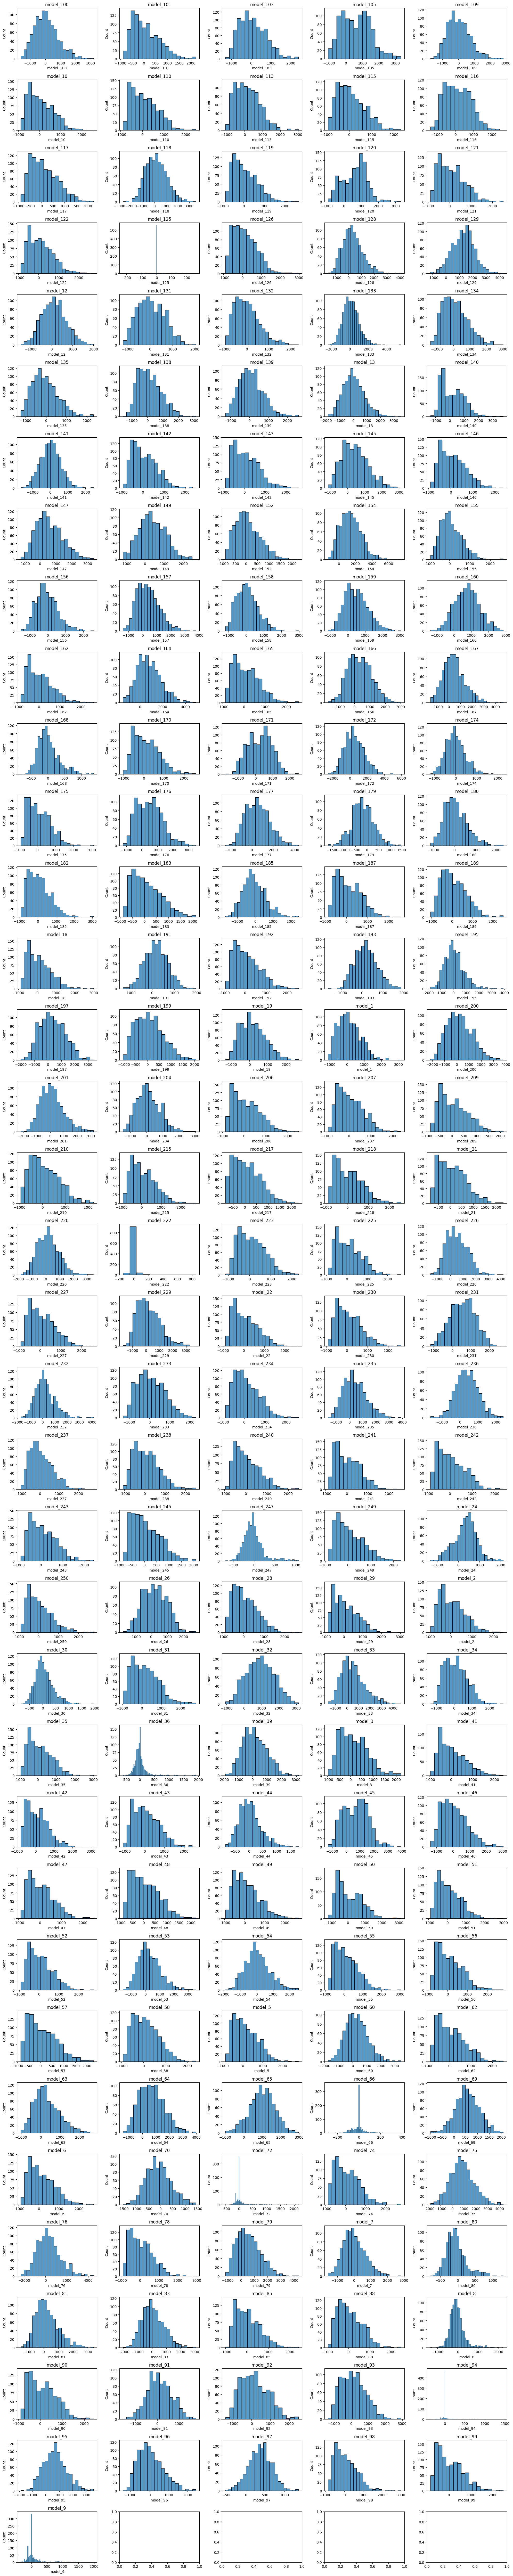

In [40]:
# Create a grid of subplots for every column in df where there are 7 rows and 7 columns that show the distribution of the data

# Create a grid of subplots
fig, axs = plt.subplots(nrows=int(np.ceil(len(df_nan_replaced.columns)/5)), ncols=5, figsize=(20, 100))

# Flatten the axs array
axs = axs.flatten()

# Iterate over the columns in df
for i, col in enumerate(df.columns):
    # Plot the distribution of the column
    sns.histplot(data=df, x=col, ax=axs[i])
    axs[i].set_title(col)

# Adjust the spacing between subplots
fig.tight_layout()

# Show the plot
plt.show()